In [27]:
import cv2  # for video rendering 
import dlib  # for face and landmark detection 
import imutils 
import os
# for calculating dist b/w the eye landmarks 
from scipy.spatial import distance as dist 
# to get the landmark ids of the left 
# and right eyes ----you can do this  
# manually too 
from imutils import face_utils 
import matplotlib.pyplot as plt
import numpy as np

In [28]:
try:
    if detector is None:
        detector = dlib.get_frontal_face_detector() 
except:
    detector = dlib.get_frontal_face_detector() 
try:
    if predictor is None:
        predictor = dlib.shape_predictor('/home/vshah/Documents/Uni/Thesis_Cluster/pupil-size-estimation-with-super-resolution/data/shape_predictor_68_face_landmarks.dat') 
except:
    predictor = dlib.shape_predictor('/home/vshah/Documents/Uni/Thesis_Cluster/pupil-size-estimation-with-super-resolution/data/shape_predictor_68_face_landmarks.dat') 

In [29]:
output_folder = "/home/vshah/Documents/Uni/Thesis_Cluster/pupil-size-estimation-with-super-resolution/preprocessing/detections/dlib"

In [30]:
IMAGE_FILE = "/home/vshah/Documents/Uni/Thesis_Cluster/pupil-size-estimation-with-super-resolution/data/EyeDentify/Wo_SR/original/6/1/frame_01.png"

In [31]:
frame = cv2.imread(IMAGE_FILE)
rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

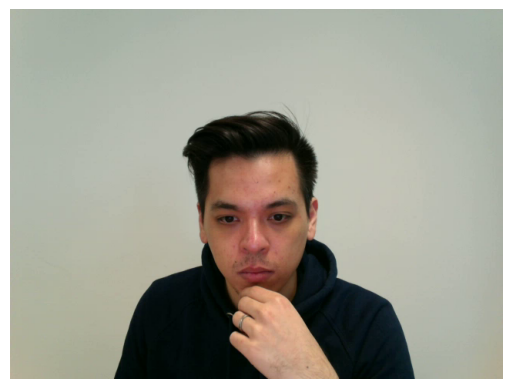

In [32]:
plt.imshow(rgb_frame)
plt.axis('off')
plt.show()

In [33]:
# detecting the faces---# 
faces = detector(rgb_frame) 

cropped_face =  (256, 256, 3)


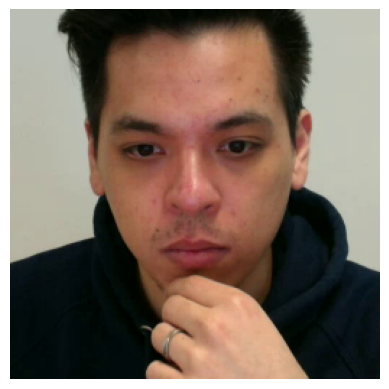

In [34]:
for face in faces:
    x, y, w, h = (face.left(), face.top(), face.width(), face.height())
    ih, iw, _ = rgb_frame.shape

    # Desired size of the cropped image
    crop_size = 256

    # Calculate the center of the face
    center_x, center_y = x + w // 2, y + h // 2

    # Calculate the cropping box coordinates
    x1 = max(center_x - crop_size // 2, 0)
    y1 = max(center_y - crop_size // 2, 0)
    x2 = x1 + crop_size
    y2 = y1 + crop_size

    # Ensure the cropping box is within the image boundaries
    if x2 > iw:
        x1 = iw - crop_size
        x2 = iw
    if y2 > ih:
        y1 = ih - crop_size
        y2 = ih

    # Crop the face
    cropped_face = rgb_frame[y1:y2, x1:x2]

    # If the cropped area is smaller than 256x256 due to image boundaries, pad the image
    # if cropped_face.shape[0] < crop_size or cropped_face.shape[1] < crop_size:
    #     cropped_face = cv2.copyMakeBorder(
    #         cropped_face,
    #         top=0,
    #         bottom=max(0, crop_size - cropped_face.shape[0]),
    #         left=0,
    #         right=max(0, crop_size - cropped_face.shape[1]),
    #         borderType=cv2.BORDER_CONSTANT,
    #         value=[0, 0, 0]  # You can change the padding color if needed
    #     )

    print("cropped_face = ", cropped_face.shape)
    # cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

# plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
# plt.axis('off')
# plt.show()

plt.imshow(cropped_face)
plt.axis('off')
plt.show()


cropped_face =  (512, 512, 3)


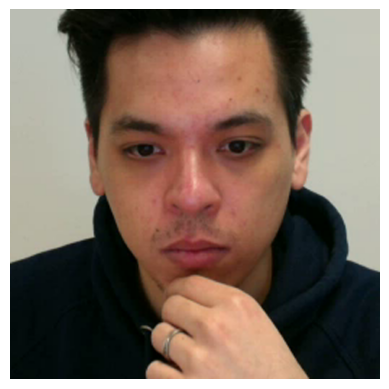

In [35]:
cropped_face = cv2.resize(cropped_face, (512, 512), interpolation=cv2.INTER_CUBIC) # bicubic upsampling
print("cropped_face = ",cropped_face.shape)
plt.imshow(cropped_face)
plt.axis('off')
plt.show()

In [36]:
cv2.imwrite(f"{output_folder}/cropped_face_image.png", cropped_face)

True

ref: https://www.geeksforgeeks.org/eye-blink-detection-with-opencv-python-and-dlib/

### Eye Aspect Ratio (EAR) 

This method is very simple, efficient, and doesn’t require anything like image processing. Basically, this ratio gives us a certain relation between the horizontal and vertical measurements of the eye. This is the equation to calculate the EAR using the six parameters of the eye :

In [37]:
def calculate_EAR(eye): 
      
    # calculate the vertical distances 
    # euclidean distance is basically  
    # the same when you calculate the 
    # hypotenuse in a right triangle 
    y1 = dist.euclidean(eye[1], eye[5]) 
    y2 = dist.euclidean(eye[2], eye[4]) 
  
    # calculate the horizontal distance 
    x1 = dist.euclidean(eye[0], eye[3]) 
  
    # calculate the EAR 
    EAR = (y1+y2) / x1 
  
    return EAR

In [38]:
blink_thresh = 0.45
# Eye landmarks 
(L_start, L_end) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"] 
(R_start, R_end) = face_utils.FACIAL_LANDMARKS_IDXS['right_eye'] 

In [39]:
# face = faces[0]
frontal_face_detector = dlib.get_frontal_face_detector()
detected_faces = frontal_face_detector(cropped_face, 1)
# landmark detection 
shape = predictor(cropped_face, detected_faces[0]) 

# converting the shape class directly 
# to a list of (x,y) coordinates 
shape = face_utils.shape_to_np(shape) 

# parsing the landmarks list to extract 
# lefteye and righteye landmarks--# 
lefteye = shape[L_start: L_end] 
righteye = shape[R_start:R_end] 

# Calculate the EAR 
left_EAR = calculate_EAR(lefteye) 
right_EAR = calculate_EAR(righteye) 

# Avg of left and right eye EAR 
avg = (left_EAR+right_EAR)/2
print(avg, " out of ", blink_thresh)

if avg < blink_thresh: 
    print("Person Blinked!")
else:
    print("Person Didn't Blinked!")

0.6028808569440873  out of  0.45
Person Didn't Blinked!


In [40]:
def extract_eyes(face):

    frontal_face_detector = dlib.get_frontal_face_detector()
    detected_faces = frontal_face_detector(face, 1)
    if len(detected_faces) == 0:
        print("No face found! Skipped eyes extraction!")
        return None

    shape = predictor(face, detected_faces[0])

    target_width = 64
    target_height = 32

    # Calculate the centers of the left and right eyes
    left_eye_center_x = (shape.part(36).x + shape.part(39).x) // 2
    left_eye_center_y = (shape.part(37).y + shape.part(40).y) // 2

    right_eye_center_x = (shape.part(42).x + shape.part(45).x) // 2
    right_eye_center_y = (shape.part(43).y + shape.part(46).y) // 2

    # Calculate the bounding boxes for cropping
    left_x1 = max(left_eye_center_x - target_width // 2, 0)
    left_x2 = left_x1 + target_width
    left_y1 = max(left_eye_center_y - target_height // 2, 0)
    left_y2 = left_y1 + target_height

    right_x1 = max(right_eye_center_x - target_width // 2, 0)
    right_x2 = right_x1 + target_width
    right_y1 = max(right_eye_center_y - target_height // 2, 0)
    right_y2 = right_y1 + target_height

    # Ensure the crop is within image boundaries
    left_eye = face[left_y1:left_y2, left_x1:left_x2]
    right_eye = face[right_y1:right_y2, right_x1:right_x2]

    # Eyes region (both eyes together)
    # eyes_x1 = shape.part(36).x
    # eyes_x2 = shape.part(45).x
    # eyes_y1 = max(shape.part(37).y, shape.part(43).y)
    # eyes_y2 = min(shape.part(40).y, shape.part(46).y)
    # eyes = face_rgb[eyes_y1 - 10 : eyes_y2 + 10, eyes_x1 - 10 : eyes_x2 + 10]

    return {
        "left_eye": left_eye,
        "right_eye": right_eye,
        # "eyes": cv2.resize(eyes, (188, 32)),
    }

In [41]:
eyes_data = extract_eyes(cropped_face)

In [42]:
eyes_data["left_eye"].shape

(32, 64, 3)

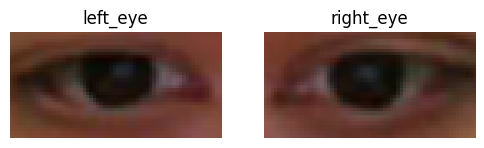

In [43]:
# Display the original image and the masked image together
fig, axes = plt.subplots(1, 2, figsize=(6, 6))
axes[0].imshow(eyes_data["left_eye"])
axes[0].axis('off')
axes[0].set_title('left_eye')
axes[1].imshow(eyes_data["right_eye"])
axes[1].axis('off')
axes[1].set_title('right_eye')
plt.show()

In [44]:
# Convert RGB image to grayscale
left_iris_gray = cv2.cvtColor(eyes_data["left_eye"], cv2.COLOR_RGB2GRAY)

# Apply Gaussian blur for denoising
left_iris_blur = cv2.GaussianBlur(left_iris_gray, (5, 5), 0)

# Perform adaptive thresholding
_, left_iris_mask = cv2.threshold(left_iris_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Invert the mask
inverted_mask_left = cv2.bitwise_not(left_iris_mask)

In [45]:
# Convert RGB image to grayscale
right_iris_gray = cv2.cvtColor(eyes_data["right_eye"], cv2.COLOR_RGB2GRAY)

# Apply Gaussian blur for denoising
right_iris_blur = cv2.GaussianBlur(right_iris_gray, (5, 5), 0)

# Perform adaptive thresholding
_, right_iris_mask = cv2.threshold(right_iris_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Invert the mask
inverted_mask_right = cv2.bitwise_not(right_iris_mask)

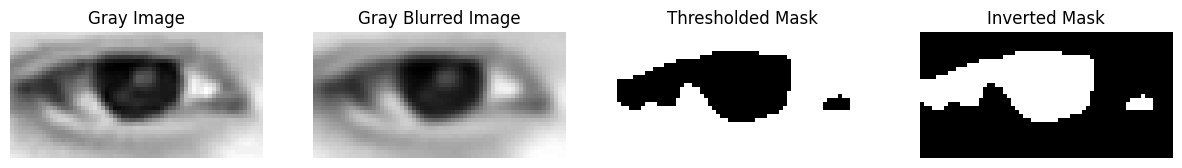

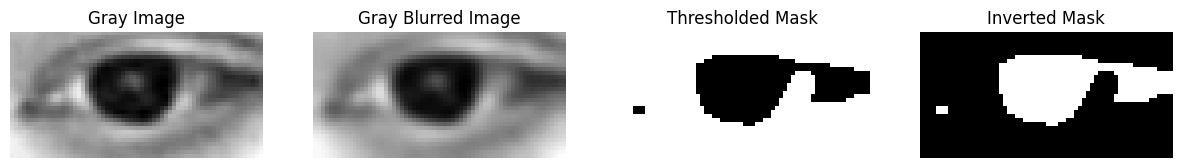

In [46]:
# Plotting
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Plot gray image
axes[0].imshow(left_iris_gray, cmap='gray')
axes[0].set_title('Gray Image')
axes[0].axis('off')

# Plot gray blurred image
axes[1].imshow(left_iris_blur, cmap='gray')
axes[1].set_title('Gray Blurred Image')
axes[1].axis('off')

# Plot thresholded mask
axes[2].imshow(left_iris_mask, cmap='gray')
axes[2].set_title('Thresholded Mask')
axes[2].axis('off')

# Plot inverted mask
axes[3].imshow(inverted_mask_left, cmap='gray')
axes[3].set_title('Inverted Mask')
axes[3].axis('off')

plt.show()

# Plotting
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Plot gray image
axes[0].imshow(right_iris_gray, cmap='gray')
axes[0].set_title('Gray Image')
axes[0].axis('off')

# Plot gray blurred image
axes[1].imshow(right_iris_blur, cmap='gray')
axes[1].set_title('Gray Blurred Image')
axes[1].axis('off')

# Plot thresholded mask
axes[2].imshow(right_iris_mask, cmap='gray')
axes[2].set_title('Thresholded Mask')
axes[2].axis('off')

# Plot inverted mask
axes[3].imshow(inverted_mask_right, cmap='gray')
axes[3].set_title('Inverted Mask')
axes[3].axis('off')

plt.show()

In [47]:
def center_crop(image, crop_width, crop_height):
    # Get the dimensions of the image
    height, width = image.shape[:2]

    # Calculate the center of the image
    center_x, center_y = width // 2, height // 2

    # Calculate the top left and bottom right coordinates of the crop
    start_x = center_x - crop_width // 2
    start_y = center_y - crop_height // 2
    end_x = start_x + crop_width
    end_y = start_y + crop_height

    # Crop the image
    cropped_image = image[start_y:end_y, start_x:end_x]

    return cropped_image

In [48]:
cropped_image_left_eye = center_crop(eyes_data["left_eye"], 32, 32)
cropped_image_right_eye = center_crop(eyes_data["right_eye"], 32, 32)

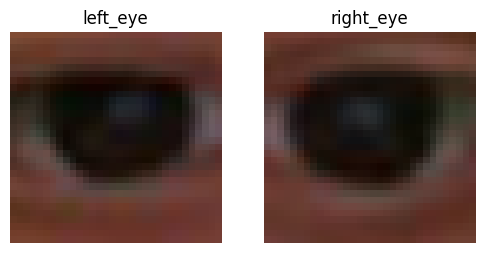

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(6, 6))
axes[0].imshow(cropped_image_left_eye)
axes[0].axis('off')
axes[0].set_title('left_eye')
axes[1].imshow(cropped_image_right_eye)
axes[1].axis('off')
axes[1].set_title('right_eye')
plt.show()

In [50]:
# Convert RGB image to grayscale
left_iris_gray = cv2.cvtColor(cropped_image_left_eye, cv2.COLOR_RGB2GRAY)

# Apply Gaussian blur for denoising
left_iris_blur = cv2.GaussianBlur(left_iris_gray, (5, 5), 0)

# Perform adaptive thresholding
_, left_iris_mask = cv2.threshold(left_iris_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Invert the mask
inverted_mask_left = cv2.bitwise_not(left_iris_mask)

In [51]:
# Convert RGB image to grayscale
right_iris_gray = cv2.cvtColor(cropped_image_right_eye, cv2.COLOR_RGB2GRAY)

# Apply Gaussian blur for denoising
right_iris_blur = cv2.GaussianBlur(right_iris_gray, (5, 5), 0)

# Perform adaptive thresholding
_, right_iris_mask = cv2.threshold(right_iris_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Invert the mask
inverted_mask_right = cv2.bitwise_not(right_iris_mask)

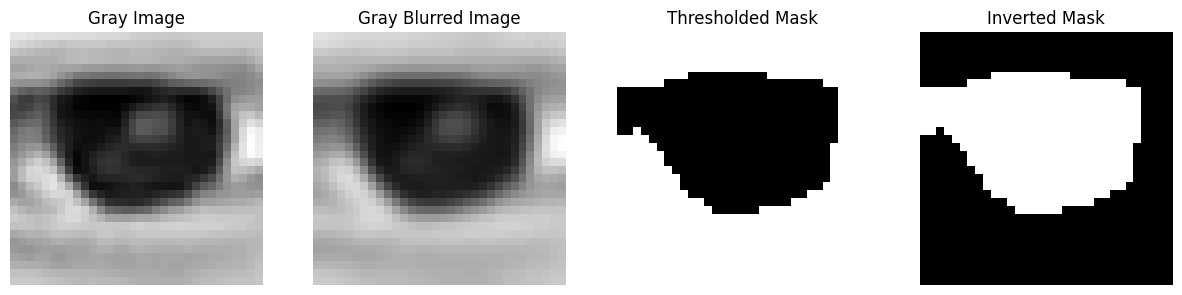

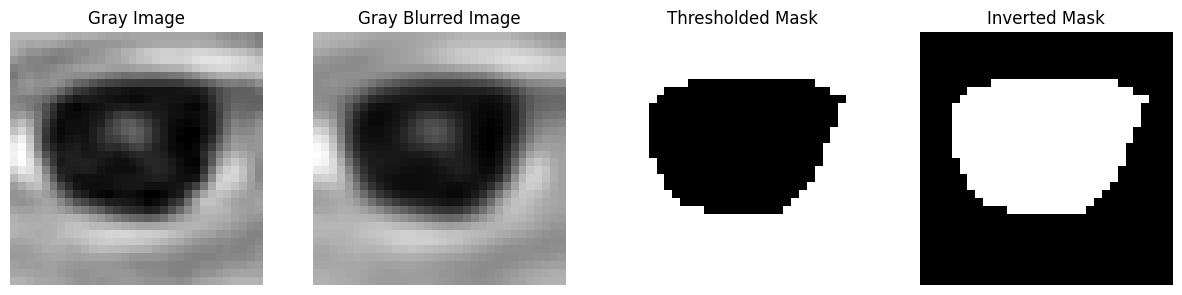

In [52]:
# Plotting
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Plot gray image
axes[0].imshow(left_iris_gray, cmap='gray')
axes[0].set_title('Gray Image')
axes[0].axis('off')

# Plot gray blurred image
axes[1].imshow(left_iris_blur, cmap='gray')
axes[1].set_title('Gray Blurred Image')
axes[1].axis('off')

# Plot thresholded mask
axes[2].imshow(left_iris_mask, cmap='gray')
axes[2].set_title('Thresholded Mask')
axes[2].axis('off')

# Plot inverted mask
axes[3].imshow(inverted_mask_left, cmap='gray')
axes[3].set_title('Inverted Mask')
axes[3].axis('off')

plt.show()

# Plotting
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Plot gray image
axes[0].imshow(right_iris_gray, cmap='gray')
axes[0].set_title('Gray Image')
axes[0].axis('off')

# Plot gray blurred image
axes[1].imshow(right_iris_blur, cmap='gray')
axes[1].set_title('Gray Blurred Image')
axes[1].axis('off')

# Plot thresholded mask
axes[2].imshow(right_iris_mask, cmap='gray')
axes[2].set_title('Thresholded Mask')
axes[2].axis('off')

# Plot inverted mask
axes[3].imshow(inverted_mask_right, cmap='gray')
axes[3].set_title('Inverted Mask')
axes[3].axis('off')

plt.show()